In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
class Network:
    def __init__(self):
        self.history = []
        self.layers = []
        self.loss = None

    def add (self, layer):
        self.layers.append(layer)

    def compile(self, loss):
        self.loss = loss
        print("Compilation...")
        for i in tqdm(range(1, len(self.layers))):
            self.layers[i].compile(self.layers[i-1].output_shape)

    def fit(self, X_train, Y_train, epochs, learning_rate):
        print("Learning...")
        for i in range(epochs):
            loss = 0
            for j in tqdm(range(len(X_train))):
                output = self.__forward(X_train[j])
                loss += self.loss.function(Y_train[j], output)
                error = self.loss.derivative(Y_train[j], output)
                self.__backward(error, learning_rate)
            loss /= len(X_train)
            self.history.append(loss)
            print(f'Epoch {i+1}/{epochs}: loss={loss}')

    def predict(self, X):
        print("Prediction...")
        result = []
        for i in tqdm(range(len(X))):
            output = self.__forward(X[i])
            result.append(output[0])
        return result

    def __forward(self, input):
        output = np.array([input])
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def __backward(self, error, learning_rate):
        gradient = error
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient, learning_rate)

In [3]:
class Activation:
    def function(x):
        pass

    def derivative(x):
        pass

class Sigmoid(Activation):
    def function(x):
        return 1 / (1 + np.exp(-x))

    def derivative(x):
        return np.exp(-x) / np.square(1 + np.exp(-x))

In [4]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

class Metric:
    def print_classification_metrics(y_true, y_pred):
        params = pd.DataFrame()
        params.index = ['Accuracy', 'Precision', 'Recall', 'F1 score']
        for label in pd.DataFrame(y_true)[0].unique():
            TP, TN, FP, FN = Metric.__get_classifiers(y_true, y_pred, label)
            params[label] = [Metric.__get_accuracy(TP, TN, FP, FN), Metric.__get_precision(TP, FP), Metric.__get_recall(TP, FN), Metric.__get_f1(TP, FP, FN)]
        print(params)

    def __get_accuracy(TP, TN, FP, FN):
        return (TP + TN) / (TP + TN + FP + FN)

    def __get_precision(TP, FP):
        return TP / (TP + FP)

    def __get_recall(TP, FN):
        return TP / (TP + FN)

    def __get_f1(TP, FP, FN):
        return 2 * (((TP / (TP + FP)) * (TP / (TP + FN))) / ((TP / (TP + FP)) + (TP / (TP + FN))))

    def __get_classifiers(y_true, y_pred, label):
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        for i in range(len(y_true)):
            if y_true[i] == label:
                if y_true[i] == y_pred[i]:
                    TP += 1
                else:
                    FN += 1
            else:
                if y_true[i] == y_pred[i]:
                    TN += 1
                else:
                    FP += 1
        return (TP, TN, FP, FN)

    def print_regression_metrics(y_true, y_pred):
        params = pd.DataFrame()
        params.index = ['MSE', 'RMSE', 'R^2']
        params[''] = [Metric.__get_mse(y_true, y_pred), Metric.__get_rmse(y_true, y_pred), Metric.__get_r2(y_true, y_pred)]
        print(params)

    def __get_mse(y_true, y_pred):
        return np.square(np.subtract(y_true, y_pred)).mean()

    def __get_rmse(y_true, y_pred):
        return np.sqrt(np.square(np.subtract(y_true, y_pred)).mean())

    def __get_r2(y_true, y_pred):
        return 1 - (np.square(np.subtract(y_true, y_pred)).sum() / np.square(y_true - y_true.mean()).sum())

class Plot:
    def plot_confusion_matrix(y_true, y_pred):
        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, colorbar=False)

    def plot_roc_curve(y_true, y_pred, labels):
        f, ax = plt.subplots()
        plt.plot([0, 1], [0, 1], linestyle="--")
        for label in labels:
            RocCurveDisplay.from_predictions(y_true, y_pred, pos_label=label, ax=ax, name=label)
            ax.set_xlabel('')
            ax.set_ylabel('')

    def plot_history_trend(history, metric):
        f, ax = plt.subplots()
        plt.plot(range(len(history)), history, label=metric)
        ax.set_title(metric)
        ax.set_xlabel("Эпоха")
        ax.legend(loc='upper left')
        plt.show()

In [5]:
class Loss:
    def function(x):
        pass

    def derivative(x):
        pass

class MSE(Loss):
    def function(y_true, y_pred):
        return np.square(np.subtract(y_pred, y_true)).mean()

    def derivative(y_true, y_pred):
        return 2 * np.subtract(y_pred, y_true) / y_true.size

class CategoricalCrossEntropy(Loss):
    def function(y_true, y_pred):
        return -np.sum(y_true * np.log(y_pred + 10**-100))

    def derivative(y_true, y_pred):
        return -y_true/(y_pred + 10**-100)

class BinaryCrossEntropy(Loss):
    def function(y_true, y_pred):
        return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

    def derivative(y_true, y_pred):
        return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

In [6]:
class Layer:
    def __init__(self) -> None:
        self.input_shape = None
        self.output_shape = None

    def compile(self, input_shape: int or tuple) -> None:
        pass

    def forward(self, input: np.ndarray) -> np.ndarray:
        pass

    def backward(self, output_gradient: np.ndarray, learning_rate: float) -> np.ndarray:
        pass

class Input(Layer):
    def __init__(self, input_shape: int or tuple) -> None:
        self.compile(input_shape)
        self.output_shape = input_shape

    def compile(self, input_shape: int or tuple) -> None:
        self.input_shape = input_shape

    def forward(self, input: np.ndarray) -> np.ndarray:
        return input

    def backward(self, output_gradient: np.ndarray, learning_rate: float) -> np.ndarray:
        return output_gradient

class Dense(Layer):
    def __init__(self, shape: int, activation: Activation) -> None:
        self.output_shape = shape
        self.activation = activation

    def compile(self, input_shape: int) -> None:
        self.bias = np.random.randn(self.output_shape, 1)
        self.weights = np.random.randn(self.output_shape, input_shape)

    def forward(self, input: np.ndarray) -> np.ndarray:
        self.input = input
        self.activation_input = np.dot(self.input[0], self.weights.T) + self.bias.T
        return self.activation.function(self.activation_input)

    def backward(self, output_gradient: np.ndarray, learning_rate: float) -> np.ndarray:
        output_gradient = np.multiply(output_gradient, self.activation.derivative(self.activation_input))
        self.weights_gradient = np.dot(np.array(self.input).T, np.array(output_gradient))
        self.weights -= learning_rate * self.weights_gradient.T
        self.bias -= learning_rate * output_gradient.T
        return np.dot(output_gradient, self.weights)

In [7]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [8]:
!pip install ucimlrepo

In [9]:
from ucimlrepo import fetch_ucirepo

mushroom = fetch_ucirepo(id=73)
X = mushroom.data.features
y = mushroom.data.targets

df = X.join(y)
rows, columns = df.shape

In [10]:
df.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g,e


In [11]:
df.columns

Index(['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment',
       'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root',
       'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type',
       'spore-print-color', 'population', 'habitat', 'poisonous'],
      dtype='object')

In [12]:
df.dtypes

,0
cap-shape,object
cap-surface,object
cap-color,object
bruises,object
odor,object
gill-attachment,object
gill-spacing,object
gill-size,object
gill-color,object
stalk-shape,object


In [13]:
for column in df.columns:
    print(f"{column}: ")
    print(df[column].unique())

cap-shape: 
['x' 'b' 's' 'f' 'k' 'c']
cap-surface: 
['s' 'y' 'f' 'g']
cap-color: 
['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises: 
['t' 'f']
odor: 
['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment: 
['f' 'a']
gill-spacing: 
['c' 'w']
gill-size: 
['n' 'b']
gill-color: 
['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape: 
['e' 't']
stalk-root: 
['e' 'c' 'b' 'r' nan]
stalk-surface-above-ring: 
['s' 'f' 'k' 'y']
stalk-surface-below-ring: 
['s' 'f' 'y' 'k']
stalk-color-above-ring: 
['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring: 
['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type: 
['p']
veil-color: 
['w' 'n' 'o' 'y']
ring-number: 
['o' 't' 'n']
ring-type: 
['p' 'e' 'l' 'f' 'n']
spore-print-color: 
['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population: 
['s' 'n' 'a' 'v' 'y' 'c']
habitat: 
['u' 'g' 'm' 'd' 'p' 'w' 'l']
poisonous: 
['p' 'e']


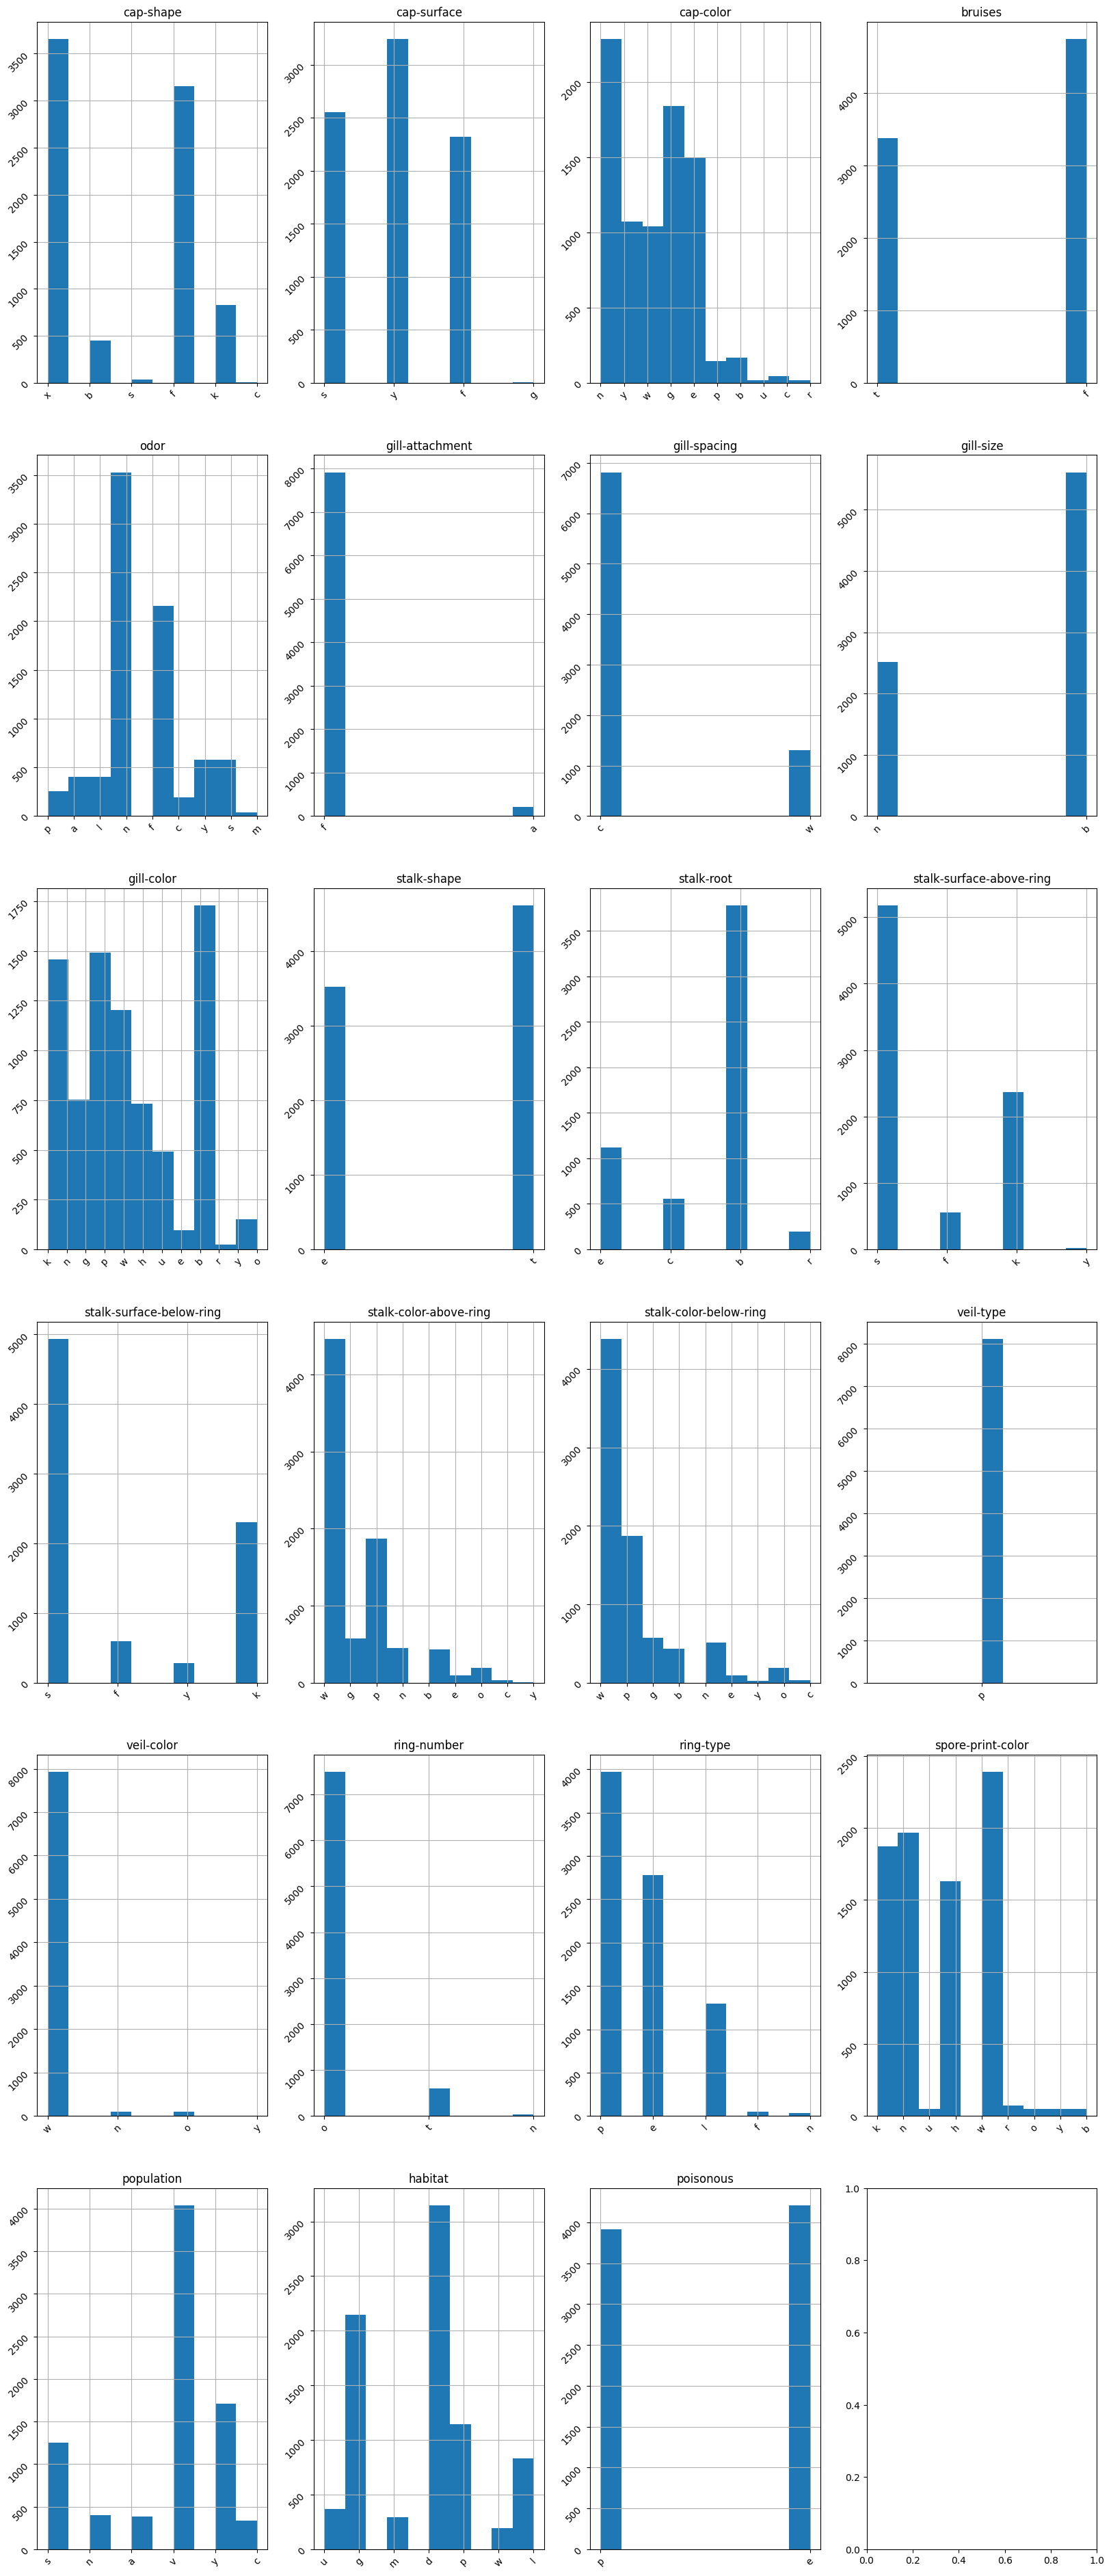

In [14]:
if columns % 4 == 0:
    f, ax = plt.subplots(int(columns // 4), 4, figsize=(20,int(columns // 4) * 8))
else:
    f, ax = plt.subplots(int(columns // 4) + 1, 4, figsize=(20,(int(columns // 4) + 1) * 8))

i = 0
j = 0
for column in df.columns:
    if j == 4:
        j = 0
        i += 1

    df[column].hist(ax=ax[i, j])
    ax[i, j].set_title(column)
    ax[i, j].tick_params(labelrotation=45)
    j += 1

<ipython-input-15-fc7f045f8d40>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='poisonous', data=pd.DataFrame(df['poisonous']), palette='hls')
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<function matplotlib.pyplot.show(close=None, block=None)>

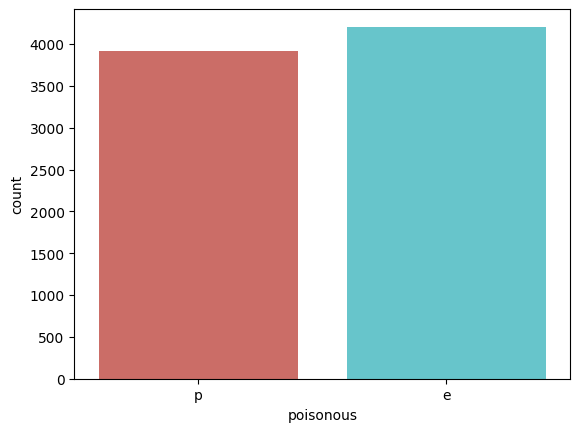

In [15]:
sns.countplot(x='poisonous', data=pd.DataFrame(df['poisonous']), palette='hls')
plt.show

In [16]:
target_le = LabelEncoder()
df['poisonous'] = target_le.fit_transform(df['poisonous'])

for column in tqdm(df.drop(columns=['poisonous']).columns):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

100%|██████████| 22/22 [00:00<00:00, 91.74it/s]


In [17]:
df.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,5,2,4,1,6,1,0,1,4,0,2,2,2,7,7,0,2,1,4,2,3,5,1
1,5,2,9,1,0,1,0,0,4,0,1,2,2,7,7,0,2,1,4,3,2,1,0
2,0,2,8,1,3,1,0,0,5,0,1,2,2,7,7,0,2,1,4,3,2,3,0
3,5,3,8,1,6,1,0,1,5,0,2,2,2,7,7,0,2,1,4,2,3,5,1
4,5,2,3,0,5,1,1,0,4,1,2,2,2,7,7,0,2,1,0,3,0,1,0


In [18]:
df.dtypes

,0
cap-shape,int64
cap-surface,int64
cap-color,int64
bruises,int64
odor,int64
gill-attachment,int64
gill-spacing,int64
gill-size,int64
gill-color,int64
stalk-shape,int64


In [19]:
rfc = RandomForestClassifier()
rfc.fit(df.drop(columns=['poisonous']), df['poisonous'])
imp = pd.Series(rfc.feature_importances_, df.drop(columns=['poisonous']).columns[0:len(df.drop(columns=['poisonous']).columns)]).sort_values()

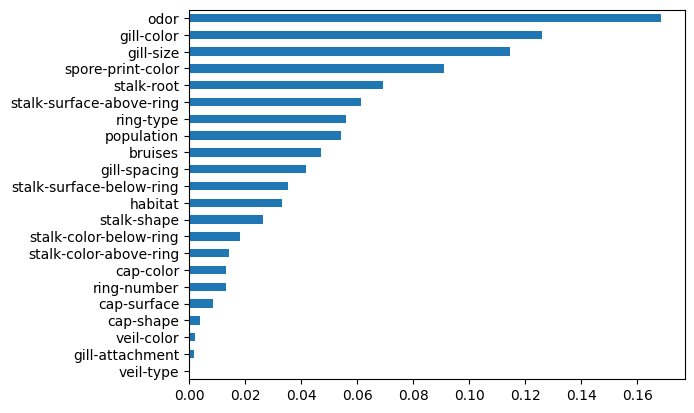

In [20]:
plt.figure()
imp.plot(kind='barh')
plt.show()

In [21]:
df = df.drop(columns=['veil-type', 'veil-color', 'gill-attachment', 'cap-shape'])
rows, columns = df.shape

In [22]:
df.head()

,cap-surface,cap-color,bruises,odor,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,2,4,1,6,0,1,4,0,2,2,2,7,7,1,4,2,3,5,1
1,2,9,1,0,0,0,4,0,1,2,2,7,7,1,4,3,2,1,0
2,2,8,1,3,0,0,5,0,1,2,2,7,7,1,4,3,2,3,0
3,3,8,1,6,0,1,5,0,2,2,2,7,7,1,4,2,3,5,1
4,2,3,0,5,1,0,4,1,2,2,2,7,7,1,0,3,0,1,0


In [23]:
df.columns

Index(['cap-surface', 'cap-color', 'bruises', 'odor', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring',
       'stalk-color-above-ring', 'stalk-color-below-ring', 'ring-number', 'ring-type',
       'spore-print-color', 'population', 'habitat', 'poisonous'],
      dtype='object')

In [24]:
X = df.drop(columns=['poisonous'])
Y = pd.get_dummies(df['poisonous'])

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [26]:
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

In [27]:
print(f"Train dataset shape: {x_train.shape}, {y_train.shape}")
print(f"Test dataset shape:  {x_test.shape}, {y_test.shape}")

Train dataset shape: (5686, 18), (5686, 2)
Test dataset shape:  (2438, 18), (2438, 2)


In [28]:
model = Network()
model.add(Input(18))
model.add(Dense(15, activation=Sigmoid))
model.add(Dense(10, activation=Sigmoid))
model.add(Dense(2, activation=Sigmoid))
model.compile(loss=MSE)
model.fit(X_train=x_train, Y_train=y_train, epochs=100, learning_rate=.01)
y_pred = model.predict(X=x_test)

Compilation...


100%|██████████| 3/3 [00:00<00:00, 12087.33it/s]


Learning...


100%|██████████| 5686/5686 [00:03<00:00, 1746.83it/s]


Epoch 1/100: loss=0.29343632114948265


100%|██████████| 5686/5686 [00:03<00:00, 1453.69it/s]


Epoch 2/100: loss=0.15491236106684597


100%|██████████| 5686/5686 [00:04<00:00, 1399.60it/s]


Epoch 3/100: loss=0.1070506178205281


100%|██████████| 5686/5686 [00:03<00:00, 1522.45it/s]


Epoch 4/100: loss=0.08665500401169038


100%|██████████| 5686/5686 [00:04<00:00, 1290.91it/s]


Epoch 5/100: loss=0.07546994426217131


100%|██████████| 5686/5686 [00:03<00:00, 1494.70it/s]


Epoch 6/100: loss=0.06681834580164836


100%|██████████| 5686/5686 [00:03<00:00, 1431.59it/s]


Epoch 7/100: loss=0.059530845550599426


100%|██████████| 5686/5686 [00:06<00:00, 944.74it/s]


Epoch 8/100: loss=0.05343582381342239


100%|██████████| 5686/5686 [00:03<00:00, 1499.68it/s]


Epoch 9/100: loss=0.0482318626332854


100%|██████████| 5686/5686 [00:02<00:00, 2119.69it/s]


Epoch 10/100: loss=0.04381760191480242


100%|██████████| 5686/5686 [00:02<00:00, 2104.05it/s]


Epoch 11/100: loss=0.039980834867508655


100%|██████████| 5686/5686 [00:01<00:00, 2848.64it/s]


Epoch 12/100: loss=0.03655259383505442


100%|██████████| 5686/5686 [00:00<00:00, 7276.15it/s]


Epoch 13/100: loss=0.03334415150965739


100%|██████████| 5686/5686 [00:00<00:00, 7133.09it/s]


Epoch 14/100: loss=0.03033636508234458


100%|██████████| 5686/5686 [00:00<00:00, 7459.92it/s]


Epoch 15/100: loss=0.027752013466317414


100%|██████████| 5686/5686 [00:00<00:00, 7275.36it/s]


Epoch 16/100: loss=0.025609896044598512


100%|██████████| 5686/5686 [00:00<00:00, 7237.25it/s]


Epoch 17/100: loss=0.02381595940551668


100%|██████████| 5686/5686 [00:01<00:00, 5330.13it/s]


Epoch 18/100: loss=0.022279446620908208


100%|██████████| 5686/5686 [00:01<00:00, 4703.16it/s]


Epoch 19/100: loss=0.020925152252726745


100%|██████████| 5686/5686 [00:01<00:00, 4195.99it/s]


Epoch 20/100: loss=0.019691394497914648


100%|██████████| 5686/5686 [00:01<00:00, 5360.37it/s]


Epoch 21/100: loss=0.01852847600083616


100%|██████████| 5686/5686 [00:00<00:00, 7173.05it/s]


Epoch 22/100: loss=0.01740661095714598


100%|██████████| 5686/5686 [00:00<00:00, 7148.51it/s]


Epoch 23/100: loss=0.016332555451458158


100%|██████████| 5686/5686 [00:00<00:00, 7217.32it/s]


Epoch 24/100: loss=0.015309613570035876


100%|██████████| 5686/5686 [00:00<00:00, 7340.52it/s]


Epoch 25/100: loss=0.014314786698222297


100%|██████████| 5686/5686 [00:00<00:00, 7302.51it/s]


Epoch 26/100: loss=0.013346871793148137


100%|██████████| 5686/5686 [00:00<00:00, 7167.13it/s]


Epoch 27/100: loss=0.012480925997225362


100%|██████████| 5686/5686 [00:00<00:00, 7155.93it/s]


Epoch 28/100: loss=0.011734594481621225


100%|██████████| 5686/5686 [00:00<00:00, 7242.29it/s]


Epoch 29/100: loss=0.01107868651030526


100%|██████████| 5686/5686 [00:00<00:00, 7566.88it/s]


Epoch 30/100: loss=0.010460465581857328


100%|██████████| 5686/5686 [00:00<00:00, 6796.91it/s]


Epoch 31/100: loss=0.009750926920263935


100%|██████████| 5686/5686 [00:00<00:00, 7153.13it/s]


Epoch 32/100: loss=0.00903095564501967


100%|██████████| 5686/5686 [00:00<00:00, 7217.82it/s]


Epoch 33/100: loss=0.00838554878364564


100%|██████████| 5686/5686 [00:01<00:00, 4462.36it/s]


Epoch 34/100: loss=0.007850951098128741


100%|██████████| 5686/5686 [00:01<00:00, 4370.91it/s]


Epoch 35/100: loss=0.007388459389314961


100%|██████████| 5686/5686 [00:01<00:00, 4053.12it/s]


Epoch 36/100: loss=0.006951469826856836


100%|██████████| 5686/5686 [00:00<00:00, 7346.27it/s]


Epoch 37/100: loss=0.006527124240336097


100%|██████████| 5686/5686 [00:00<00:00, 7305.64it/s]


Epoch 38/100: loss=0.006134329812819741


100%|██████████| 5686/5686 [00:00<00:00, 7134.40it/s]


Epoch 39/100: loss=0.005776584443694573


100%|██████████| 5686/5686 [00:00<00:00, 7284.82it/s]


Epoch 40/100: loss=0.005448901375528271


100%|██████████| 5686/5686 [00:00<00:00, 7332.36it/s]


Epoch 41/100: loss=0.005145466512484594


100%|██████████| 5686/5686 [00:00<00:00, 7050.71it/s]


Epoch 42/100: loss=0.004864115406855281


100%|██████████| 5686/5686 [00:00<00:00, 7198.16it/s]


Epoch 43/100: loss=0.004603629485787712


100%|██████████| 5686/5686 [00:00<00:00, 6998.61it/s]


Epoch 44/100: loss=0.004361844139675338


100%|██████████| 5686/5686 [00:00<00:00, 7392.60it/s]


Epoch 45/100: loss=0.004136521642149727


100%|██████████| 5686/5686 [00:00<00:00, 7192.06it/s]


Epoch 46/100: loss=0.003926055754057925


100%|██████████| 5686/5686 [00:00<00:00, 7081.40it/s]


Epoch 47/100: loss=0.0037294192629051992


100%|██████████| 5686/5686 [00:00<00:00, 7298.03it/s]


Epoch 48/100: loss=0.0035459573635948823


100%|██████████| 5686/5686 [00:01<00:00, 5426.28it/s]


Epoch 49/100: loss=0.003375239160229891


100%|██████████| 5686/5686 [00:01<00:00, 4661.97it/s]


Epoch 50/100: loss=0.0032168930622375586


100%|██████████| 5686/5686 [00:01<00:00, 4140.73it/s]


Epoch 51/100: loss=0.0030704541434652217


100%|██████████| 5686/5686 [00:01<00:00, 5095.08it/s]


Epoch 52/100: loss=0.0029353000105165174


100%|██████████| 5686/5686 [00:00<00:00, 7067.90it/s]


Epoch 53/100: loss=0.0028106769441249417


100%|██████████| 5686/5686 [00:00<00:00, 7098.46it/s]


Epoch 54/100: loss=0.002695765856934317


100%|██████████| 5686/5686 [00:00<00:00, 7300.23it/s]


Epoch 55/100: loss=0.002589744087535901


100%|██████████| 5686/5686 [00:00<00:00, 7459.76it/s]


Epoch 56/100: loss=0.0024918251283158315


100%|██████████| 5686/5686 [00:00<00:00, 7040.60it/s]


Epoch 57/100: loss=0.0024012769825541747


100%|██████████| 5686/5686 [00:00<00:00, 7197.55it/s]


Epoch 58/100: loss=0.0023174267244660094


100%|██████████| 5686/5686 [00:00<00:00, 7236.69it/s]


Epoch 59/100: loss=0.0022396584912010064


100%|██████████| 5686/5686 [00:00<00:00, 7233.19it/s]


Epoch 60/100: loss=0.0021674093968096437


100%|██████████| 5686/5686 [00:00<00:00, 7352.03it/s]


Epoch 61/100: loss=0.0021001653976869495


100%|██████████| 5686/5686 [00:00<00:00, 7165.07it/s]


Epoch 62/100: loss=0.0020374577056665234


100%|██████████| 5686/5686 [00:00<00:00, 7185.33it/s]


Epoch 63/100: loss=0.0019788597452661664


100%|██████████| 5686/5686 [00:00<00:00, 7456.68it/s]


Epoch 64/100: loss=0.0019239844941895982


100%|██████████| 5686/5686 [00:01<00:00, 4544.29it/s]


Epoch 65/100: loss=0.0018724820520535908


100%|██████████| 5686/5686 [00:01<00:00, 4501.27it/s]


Epoch 66/100: loss=0.0018240373208804836


100%|██████████| 5686/5686 [00:01<00:00, 4199.98it/s]


Epoch 67/100: loss=0.0017783677136012114


100%|██████████| 5686/5686 [00:00<00:00, 7284.94it/s]


Epoch 68/100: loss=0.0017352208324973848


100%|██████████| 5686/5686 [00:00<00:00, 7079.67it/s]


Epoch 69/100: loss=0.0016943720848376007


100%|██████████| 5686/5686 [00:00<00:00, 7401.18it/s]


Epoch 70/100: loss=0.0016556222314251844


100%|██████████| 5686/5686 [00:00<00:00, 7230.34it/s]


Epoch 71/100: loss=0.0016187948936137416


100%|██████████| 5686/5686 [00:00<00:00, 7128.79it/s]


Epoch 72/100: loss=0.001583734070093332


100%|██████████| 5686/5686 [00:00<00:00, 7316.20it/s]


Epoch 73/100: loss=0.0015503017302090569


100%|██████████| 5686/5686 [00:00<00:00, 7298.59it/s]


Epoch 74/100: loss=0.0015183755519646055


100%|██████████| 5686/5686 [00:00<00:00, 7302.63it/s]


Epoch 75/100: loss=0.00148784686066888


100%|██████████| 5686/5686 [00:00<00:00, 7216.35it/s]


Epoch 76/100: loss=0.001458618802877124


100%|██████████| 5686/5686 [00:00<00:00, 6988.56it/s]


Epoch 77/100: loss=0.0014306047662425952


100%|██████████| 5686/5686 [00:00<00:00, 7589.65it/s]


Epoch 78/100: loss=0.001403727034889472


100%|██████████| 5686/5686 [00:00<00:00, 7163.83it/s]


Epoch 79/100: loss=0.0013779156553734792


100%|██████████| 5686/5686 [00:01<00:00, 5414.59it/s]


Epoch 80/100: loss=0.0013531074810085677


100%|██████████| 5686/5686 [00:01<00:00, 4731.01it/s]


Epoch 81/100: loss=0.0013292453611703137


100%|██████████| 5686/5686 [00:01<00:00, 4042.80it/s]


Epoch 82/100: loss=0.0013062774451479506


100%|██████████| 5686/5686 [00:00<00:00, 6354.39it/s]


Epoch 83/100: loss=0.0012841565752180957


100%|██████████| 5686/5686 [00:00<00:00, 7210.50it/s]


Epoch 84/100: loss=0.0012628397493377322


100%|██████████| 5686/5686 [00:00<00:00, 7347.15it/s]


Epoch 85/100: loss=0.0012422876392539745


100%|██████████| 5686/5686 [00:00<00:00, 7074.57it/s]


Epoch 86/100: loss=0.0012224641544344866


100%|██████████| 5686/5686 [00:00<00:00, 7147.98it/s]


Epoch 87/100: loss=0.0012033360458732778


100%|██████████| 5686/5686 [00:00<00:00, 7342.76it/s]


Epoch 88/100: loss=0.0011848725465295018


100%|██████████| 5686/5686 [00:00<00:00, 7103.78it/s]


Epoch 89/100: loss=0.0011670450469855286


100%|██████████| 5686/5686 [00:00<00:00, 7297.41it/s]


Epoch 90/100: loss=0.0011498268059656703


100%|██████████| 5686/5686 [00:00<00:00, 7038.35it/s]


Epoch 91/100: loss=0.0011331926957479119


100%|██████████| 5686/5686 [00:00<00:00, 7387.04it/s]


Epoch 92/100: loss=0.0011171189823526361


100%|██████████| 5686/5686 [00:00<00:00, 7192.95it/s]


Epoch 93/100: loss=0.0011015831398480983


100%|██████████| 5686/5686 [00:00<00:00, 7115.70it/s]


Epoch 94/100: loss=0.0010865636973302723


100%|██████████| 5686/5686 [00:00<00:00, 6113.17it/s]


Epoch 95/100: loss=0.0010720401162757568


100%|██████████| 5686/5686 [00:01<00:00, 4549.24it/s]


Epoch 96/100: loss=0.0010579926951784751


100%|██████████| 5686/5686 [00:01<00:00, 4181.60it/s]


Epoch 97/100: loss=0.001044402497777981


100%|██████████| 5686/5686 [00:01<00:00, 4496.45it/s]


Epoch 98/100: loss=0.0010312513008392883


100%|██████████| 5686/5686 [00:00<00:00, 7152.42it/s]


Epoch 99/100: loss=0.0010185215573742148


100%|██████████| 5686/5686 [00:00<00:00, 7188.25it/s]


Epoch 100/100: loss=0.001006196371380836
Prediction...


100%|██████████| 2438/2438 [00:00<00:00, 26903.26it/s]


In [29]:
pred = list()
true = list()
for i in tqdm(range(len(y_pred))):
    pred.append(np.argmax(y_pred[i]))
    true.append(np.argmax(y_test[i]))
true = target_le.inverse_transform(true)
pred = target_le.inverse_transform(pred)

100%|██████████| 2438/2438 [00:00<00:00, 190820.95it/s]


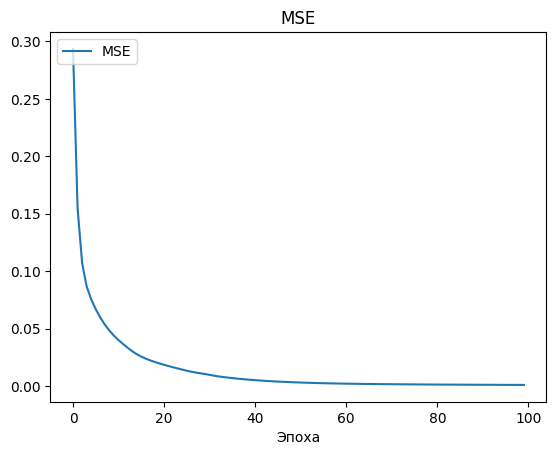

In [30]:
Plot.plot_history_trend(history=model.history, metric='MSE')

In [31]:
Metric.print_classification_metrics(y_true=true, y_pred=pred)

                  e         p
Accuracy   0.999180  0.999180
Precision  0.998411  1.000000
Recall     1.000000  0.998307
F1 score   0.999205  0.999153


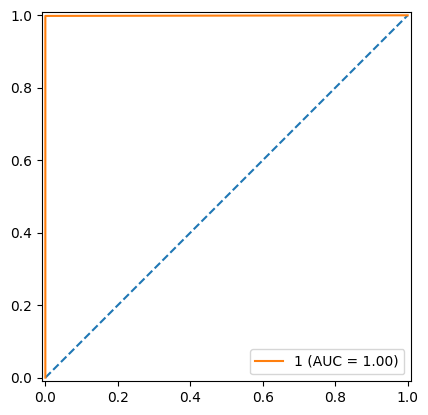

In [32]:
Plot.plot_roc_curve(y_true=target_le.transform(true), y_pred=target_le.transform(pred), labels=[1])